In [1]:
import warnings
warnings.filterwarnings("ignore")
from codecs import ignore_errors
from carla import MLModelCatalog
from carla.data.catalog.online_catalog import OnlineCatalog
from carla.recourse_methods import GrowingSpheres, Wachter, CRUD 
from sklearn.linear_model import LogisticRegression
from carla.recourse_methods import CCHVAE, balanceCCHVAE
from carla import Benchmark
from carla.models.negative_instances import predict_negative_instances
import numpy as np
import argparse 
import logging 
from utils_recourse import *
from carla.data.catalog import CsvCatalog
import pandas as pd 
import copy 


Using TensorFlow backend.


[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]


In [2]:
np.random.seed(0)
seed_everything(0)
set_style()

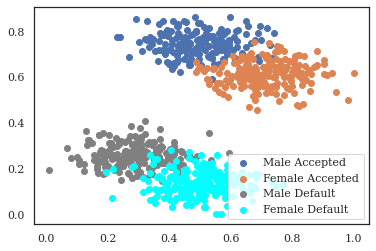

In [3]:
malepay_size = 200
femalepay_size = 200
malenotpay_size = 200
femalenotpay_size = 200
mu1 = np.array([0,10])
mu2 = np.array([5,5])
mu3 = np.array([-5,-10])
mu4 = np.array([0,-15])
sigma1 = np.array([[5,0],[0,5]])
sigma2 = np.array([[5,0],[0,5]])
sigma3 = np.array([[5,0],[0,5]])
sigma4 = np.array([[5,0],[0,5]]) 
male_repay = np.random.multivariate_normal(mean = mu1, cov = sigma1, size = malepay_size)
female_repay = np.random.multivariate_normal(mean = mu2 , cov = sigma2, size = femalepay_size)

male_default = np.random.multivariate_normal(mean = mu3, cov = sigma3, size = malenotpay_size)
female_default = np.random.multivariate_normal(mean = mu4, cov = sigma4, size = femalenotpay_size)

all_data = np.concatenate([male_repay, female_repay, male_default, female_default])
y = np.array([1]*malepay_size+[1]*femalepay_size+[0]*malenotpay_size+[0]*femalenotpay_size)
sens = np.concatenate([np.ones(malepay_size),np.zeros(femalepay_size), \
    np.ones(malenotpay_size),np.zeros(femalenotpay_size)])
labels = np.concatenate([np.ones(malepay_size),np.ones(femalepay_size), \
    np.zeros(malenotpay_size),np.zeros(femalenotpay_size)])

# reshape to [0,1]
#'''
all_data[:,0] = (all_data[:,0]) / np.max(np.abs(all_data[:,0]))
all_data[:,0] = (all_data[:,0] + 1) / 2
all_data[:,1] = (all_data[:,1]) / np.max(np.abs(all_data[:,1]))
all_data[:,1] = (all_data[:,1] + 1) / 2
#'''
import matplotlib.pyplot as plt 
plt.scatter(all_data[:,0][np.logical_and(sens==1,y==1)],all_data[:,1][np.logical_and(sens==1,y==1)],label = 'Male Accepted')
plt.scatter(all_data[:,0][np.logical_and(sens==0,y==1)],all_data[:,1][np.logical_and(sens==0,y==1)],label = 'Female Accepted')
plt.scatter(all_data[:,0][np.logical_and(sens==1,y==0)],all_data[:,1][np.logical_and(sens==1,y==0)],label = 'Male Default',color='grey')
plt.scatter(all_data[:,0][np.logical_and(sens==0,y==0)],all_data[:,1][np.logical_and(sens==0,y==0)],label = 'Female Default',color='cyan')
plt.legend()
plt.show()
plt.savefig(f'./log/synfig/syn_original.pdf')
plt.close()
import pandas as pd 
df = pd.DataFrame(data = {'x1':all_data[:,0], 'x2':all_data[:,1], "sex":(sens).astype(int), \
"y": (labels).astype(int)})        
df = df.sample(frac=1)
df.to_csv('./data/synthetic_impact/syn.csv', index=False)
df.to_csv('./balance_data/syn_train.csv', index = False)
continuous = ['x1','x2']
categorical = ['sex']
immutable = ['sex']
dataset = CsvCatalog(file_path="./data/synthetic_impact/syn.csv",
                    continuous=continuous,
                    categorical=categorical,
                    immutables=immutable,
                    scaling_method="Identity",
                    target='y')   

In [4]:
ml_model = MLModelCatalog(
    dataset,
    model_type="linear",
    load_online=False,
    backend="pytorch", 
    force_train = True
)
training_params = {"lr": 1e-1, "epochs": 200, "batch_size": 32, "hidden_size": [1024]}
ml_model.train(
    learning_rate=training_params["lr"],
    epochs=training_params["epochs"],
    batch_size=training_params["batch_size"],
    hidden_size=training_params["hidden_size"], 
    force_train = True
)
labels = ml_model.predict(dataset.df_test)
labels = (labels > 0.5 ) * 1
print(f'accuracy of trained model is {np.mean([i==j for i,j in zip(labels, dataset.df_test[dataset.target].values)])}')

labels = ml_model.predict(dataset.df_train)
labels = (labels > 0.5 ) * 1
print(f'accuracy of trained model is {np.mean([i==j for i,j in zip(labels, dataset.df_train[dataset.target].values)])}')

balance on test set 0.5083333333333333, balance on test set 0.475
Epoch 0/199
----------
train Loss: 0.3102 Acc: 0.9300

test Loss: 0.1321 Acc: 1.0000

Epoch 1/199
----------
train Loss: 0.1053 Acc: 1.0000

test Loss: 0.0767 Acc: 1.0000

Epoch 2/199
----------
train Loss: 0.0671 Acc: 1.0000

test Loss: 0.0537 Acc: 1.0000

Epoch 3/199
----------
train Loss: 0.0492 Acc: 1.0000

test Loss: 0.0404 Acc: 1.0000

Epoch 4/199
----------
train Loss: 0.0382 Acc: 1.0000

test Loss: 0.0325 Acc: 1.0000

Epoch 5/199
----------
train Loss: 0.0310 Acc: 1.0000

test Loss: 0.0262 Acc: 1.0000

Epoch 6/199
----------
train Loss: 0.0257 Acc: 1.0000

test Loss: 0.0220 Acc: 1.0000

Epoch 7/199
----------
train Loss: 0.0217 Acc: 1.0000

test Loss: 0.0186 Acc: 1.0000

Epoch 8/199
----------
train Loss: 0.0185 Acc: 1.0000

test Loss: 0.0165 Acc: 1.0000

Epoch 9/199
----------
train Loss: 0.0162 Acc: 1.0000

test Loss: 0.0139 Acc: 1.0000

Epoch 10/199
----------
train Loss: 0.0142 Acc: 1.0000

test Loss: 0.0125 

test Loss: 0.0000 Acc: 1.0000

Epoch 101/199
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 102/199
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 103/199
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 104/199
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 105/199
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 106/199
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 107/199
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 108/199
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 109/199
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 110/199
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 111/199
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

E

In [5]:
result = pd.DataFrame(columns = ['metric','value','method'])
sensitive = "sex_1"

In [6]:
pred = (ml_model.predict(dataset.df_train) > 0.5) * 1.
pred_origin = ((ml_model.predict(dataset.df_train) > 0.5) * 1.).reshape(-1)
p_central, radius = centralization(dataset.df_train[sensitive].values, \
    dataset.df_train[['x1','x2']].values)
print(f'Previous Centralization is {p_central}')
p_atkinson = atkinson(dataset.df_train[sensitive].values,\
    dataset.df_train[['x1','x2']].values, \
    origin_features = dataset.df_train[['x1','x2']].values, \
            #y = dataset.df_train[dataset.target])
)
p_atkinson = atkinson(dataset.df_train[sensitive].values,\
    dataset.df_train[['x1','x2']].values, \
    origin_features = dataset.df_train[['x1','x2']].values[pred_origin == 1], \
)    
print(f'Previous Atkinson is {p_atkinson}')
sen_feature = sensitive
mutable_feature = ['x1','x2']
a = dataset.df_train
p_ap = avg_proximity2(a[sen_feature].values,\
    a[mutable_feature].values)
print(f'Previous Avg Proximity is {p_ap}')

result = result.append({'metric':'centralization_pre', \
    'value': p_central, 'method': 'None'}, ignore_index = True)
result = result.append({'metric':'atkinson_pre', \
    'value': p_atkinson, 'method': 'None'}, ignore_index = True)
result = result.append({'metric':'avgproxi_pre', \
    'value': p_ap, 'method': 'None'}, ignore_index = True)


Previous Centralization is 0.4930555555555556
Previous Atkinson is 0.7977247848552864
Previous Avg Proximity is 0.6626241039997373


In [7]:
df.to_csv('./balance_data/syn_train.csv')

# WATCHER

[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactua

[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactua

[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactua

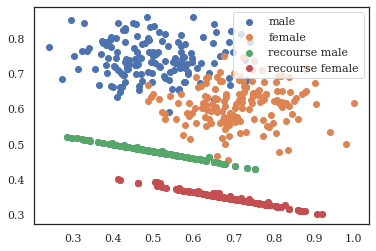

Current Centralization is 0.5
Current Atkinson is 0.8235359641207509
Current Avg Proxi Index is 0.7355946454690031
invalidation is 0.0
0.30451324088887305
0.28917617954596697
0.015337061342906078
(295, 4)
(295,)


In [8]:
hyperparams = {"loss_type": "BCE", "binary_cat_features": True}
ar_model = Wachter(ml_model, hyperparams)

negative_instances = dataset.df_train[ml_model.predict(dataset.df_train)<0.5]
negative_instances.to_csv('./balance_data/syn_negative_instances.csv')
cf = ar_model.get_counterfactuals(negative_instances)
cf.index = negative_instances.index
sensitive = "sex_1"

import matplotlib.pyplot as plt
import copy 
current_population = copy.deepcopy(dataset.df_train)

cf = encode_constraint(cf, negative_instances, [sensitive])
current_population = copy.deepcopy(dataset.df_train)
current_population.loc[negative_instances.index,['x1','x2',sensitive]] = cf[['x1','x2',sensitive]].values
current_population = current_population.dropna()
plt.scatter(current_population.x1[current_population[sensitive]==1],current_population.x2[current_population[sensitive]==1],label='male')
plt.scatter(current_population.x1[current_population[sensitive]==0],current_population.x2[current_population[sensitive]==0],label='female')
temp1 = cf['x1'][negative_instances[sensitive]==1]
temp2 = cf['x2'][negative_instances[sensitive]==1]
# randomization for visual purpose 
noise = 0
plt.scatter(temp1 + np.random.uniform(size=len(temp1)) * noise,\
    temp2 + np.random.uniform(size=len(temp2)) * noise, label = 'recourse male')
temp1 = cf['x1'][negative_instances[sensitive]==0]
temp2 = cf['x2'][negative_instances[sensitive]==0]
plt.scatter(temp1 + np.random.uniform(size=len(temp1)) * noise,\
    temp2 + np.random.uniform(size=len(temp2)) * noise, label = 'recourse female')
plt.legend()
plt.show()
plt.savefig(f'./log/synfig/syn_wachter_after.pdf')
plt.close()

features = ['x1','x2']
pred = (ml_model.predict(current_population) > 0.5).reshape(-1)
predprob = (ml_model.predict(current_population)).reshape(-1)
c_central, radius = centralization(current_population[sen_feature].values, \
    current_population[features].values, 
    radius
    )
print(f'Current Centralization is {c_central}')
c_atkinson = atkinson(current_population[sen_feature].values, \
    current_population[features].values, \
    origin_features = dataset.df_train[mutable_feature].values)
print(f'Current Atkinson is {c_atkinson}')
a = current_population
b = dataset.df_train
c_ap = avg_proximity2(a[sen_feature].values, \
    a[features].values)
print(f'Current Avg Proxi Index is {c_ap}')    

inv_rate = invalidation(cf, ml_model)
print(f'invalidation is {inv_rate}')
rec_cost = recourse_cost(negative_instances, cf)

negative_sens = negative_instances[sensitive]
rec_fair = fairness_cost(negative_instances, cf, negative_sens)

vynn = ynn(dataset.df[cf.columns], cf, ml_model, 5)
close = closeness(cf[mutable_feature], dataset.df[dataset.df.y==1][mutable_feature])
result = result.append({'metric':'centralization_after', \
    'value': c_central, 'method': 'Watcher'}, ignore_index = True)
result = result.append({'metric':'atkinson_after', \
    'value': c_atkinson, 'method': 'Watcher'}, ignore_index = True)
result = result.append({'metric':'avgproxi_after', \
    'value': c_ap, 'method': 'Watcher'}, ignore_index = True)

result = result.append({'metric':'inv_rate', \
    'value': inv_rate, 'method': 'Watcher'}, ignore_index = True)
result = result.append({ 'metric':'recourse_cost', \
    'value': rec_cost,  'method': 'Watcher'}, ignore_index = True)
result = result.append({ 'metric':'recourse_faircost', \
    'value': rec_fair,  'method': 'Watcher'}, ignore_index = True) 
result = result.append({ 'metric':'ynn', \
    'value': vynn,  'method': 'Watcher'}, ignore_index = True)             
result.value = result.value.astype(float)

In [9]:
result 

,metric,value,method
0,centralization_pre,0.493056,None
1,atkinson_pre,0.797725,None
2,avgproxi_pre,0.662624,None
3,centralization_after,0.500000,Watcher
4,atkinson_after,0.823536,Watcher
5,avgproxi_after,0.735595,Watcher
6,inv_rate,0.000000,Watcher
7,recourse_cost,0.296403,Watcher
8,recourse_faircost,0.015337,Watcher
9,ynn,0.649492,Watcher


# CCHVAE

[INFO] Start training of Variational Autoencoder... [vae.py fit]
[INFO] [Epoch: 0/1000] [objective: 43.370] [vae.py fit]
[INFO] [ELBO train: 43.37] [vae.py fit]
[INFO] [ELBO train: 40.0] [vae.py fit]
[INFO] [ELBO train: 38.26] [vae.py fit]
[INFO] [ELBO train: 38.17] [vae.py fit]
[INFO] [ELBO train: 38.15] [vae.py fit]
[INFO] [ELBO train: 38.1] [vae.py fit]
[INFO] [ELBO train: 38.09] [vae.py fit]
[INFO] [ELBO train: 38.04] [vae.py fit]
[INFO] [ELBO train: 38.0] [vae.py fit]
[INFO] [ELBO train: 37.98] [vae.py fit]
[INFO] [Epoch: 10/1000] [objective: 37.971] [vae.py fit]
[INFO] [ELBO train: 37.97] [vae.py fit]
[INFO] [ELBO train: 37.97] [vae.py fit]
[INFO] [ELBO train: 38.02] [vae.py fit]
[INFO] [ELBO train: 38.05] [vae.py fit]
[INFO] [ELBO train: 38.07] [vae.py fit]
[INFO] [ELBO train: 38.08] [vae.py fit]
[INFO] [ELBO train: 38.15] [vae.py fit]
[INFO] [ELBO train: 38.17] [vae.py fit]
[INFO] [ELBO train: 38.18] [vae.py fit]
[INFO] [ELBO train: 38.21] [vae.py fit]
[INFO] [Epoch: 20/1000] [

[INFO] [ELBO train: 40.07] [vae.py fit]
[INFO] [ELBO train: 40.12] [vae.py fit]
[INFO] [Epoch: 180/1000] [objective: 40.046] [vae.py fit]
[INFO] [ELBO train: 40.05] [vae.py fit]
[INFO] [ELBO train: 40.04] [vae.py fit]
[INFO] [ELBO train: 40.18] [vae.py fit]
[INFO] [ELBO train: 39.98] [vae.py fit]
[INFO] [ELBO train: 40.13] [vae.py fit]
[INFO] [ELBO train: 40.03] [vae.py fit]
[INFO] [ELBO train: 40.1] [vae.py fit]
[INFO] [ELBO train: 40.16] [vae.py fit]
[INFO] [ELBO train: 40.02] [vae.py fit]
[INFO] [ELBO train: 40.2] [vae.py fit]
[INFO] [Epoch: 190/1000] [objective: 40.185] [vae.py fit]
[INFO] [ELBO train: 40.19] [vae.py fit]
[INFO] [ELBO train: 40.23] [vae.py fit]
[INFO] [ELBO train: 40.3] [vae.py fit]
[INFO] [ELBO train: 40.15] [vae.py fit]
[INFO] [ELBO train: 40.27] [vae.py fit]
[INFO] [ELBO train: 40.28] [vae.py fit]
[INFO] [ELBO train: 40.14] [vae.py fit]
[INFO] [ELBO train: 40.25] [vae.py fit]
[INFO] [ELBO train: 40.18] [vae.py fit]
[INFO] [ELBO train: 40.26] [vae.py fit]
[INFO] 

[INFO] [ELBO train: 41.38] [vae.py fit]
[INFO] [ELBO train: 41.32] [vae.py fit]
[INFO] [Epoch: 360/1000] [objective: 41.058] [vae.py fit]
[INFO] [ELBO train: 41.06] [vae.py fit]
[INFO] [ELBO train: 41.12] [vae.py fit]
[INFO] [ELBO train: 41.49] [vae.py fit]
[INFO] [ELBO train: 41.32] [vae.py fit]
[INFO] [ELBO train: 41.39] [vae.py fit]
[INFO] [ELBO train: 41.47] [vae.py fit]
[INFO] [ELBO train: 41.55] [vae.py fit]
[INFO] [ELBO train: 41.26] [vae.py fit]
[INFO] [ELBO train: 41.47] [vae.py fit]
[INFO] [ELBO train: 41.47] [vae.py fit]
[INFO] [Epoch: 370/1000] [objective: 41.345] [vae.py fit]
[INFO] [ELBO train: 41.35] [vae.py fit]
[INFO] [ELBO train: 41.3] [vae.py fit]
[INFO] [ELBO train: 41.34] [vae.py fit]
[INFO] [ELBO train: 41.55] [vae.py fit]
[INFO] [ELBO train: 41.48] [vae.py fit]
[INFO] [ELBO train: 41.44] [vae.py fit]
[INFO] [ELBO train: 41.45] [vae.py fit]
[INFO] [ELBO train: 41.5] [vae.py fit]
[INFO] [ELBO train: 41.52] [vae.py fit]
[INFO] [ELBO train: 41.35] [vae.py fit]
[INFO]

[INFO] [ELBO train: 42.14] [vae.py fit]
[INFO] [ELBO train: 42.42] [vae.py fit]
[INFO] [Epoch: 540/1000] [objective: 42.300] [vae.py fit]
[INFO] [ELBO train: 42.3] [vae.py fit]
[INFO] [ELBO train: 42.29] [vae.py fit]
[INFO] [ELBO train: 42.29] [vae.py fit]
[INFO] [ELBO train: 42.24] [vae.py fit]
[INFO] [ELBO train: 42.38] [vae.py fit]
[INFO] [ELBO train: 42.22] [vae.py fit]
[INFO] [ELBO train: 42.27] [vae.py fit]
[INFO] [ELBO train: 42.17] [vae.py fit]
[INFO] [ELBO train: 42.15] [vae.py fit]
[INFO] [ELBO train: 42.25] [vae.py fit]
[INFO] [Epoch: 550/1000] [objective: 42.286] [vae.py fit]
[INFO] [ELBO train: 42.29] [vae.py fit]
[INFO] [ELBO train: 42.23] [vae.py fit]
[INFO] [ELBO train: 42.29] [vae.py fit]
[INFO] [ELBO train: 42.27] [vae.py fit]
[INFO] [ELBO train: 42.29] [vae.py fit]
[INFO] [ELBO train: 42.34] [vae.py fit]
[INFO] [ELBO train: 42.42] [vae.py fit]
[INFO] [ELBO train: 42.25] [vae.py fit]
[INFO] [ELBO train: 42.04] [vae.py fit]
[INFO] [ELBO train: 42.26] [vae.py fit]
[INFO

[INFO] [ELBO train: 42.78] [vae.py fit]
[INFO] [ELBO train: 42.64] [vae.py fit]
[INFO] [Epoch: 720/1000] [objective: 42.860] [vae.py fit]
[INFO] [ELBO train: 42.86] [vae.py fit]
[INFO] [ELBO train: 42.8] [vae.py fit]
[INFO] [ELBO train: 42.82] [vae.py fit]
[INFO] [ELBO train: 43.01] [vae.py fit]
[INFO] [ELBO train: 42.92] [vae.py fit]
[INFO] [ELBO train: 42.66] [vae.py fit]
[INFO] [ELBO train: 42.69] [vae.py fit]
[INFO] [ELBO train: 43.02] [vae.py fit]
[INFO] [ELBO train: 42.91] [vae.py fit]
[INFO] [ELBO train: 42.66] [vae.py fit]
[INFO] [Epoch: 730/1000] [objective: 43.063] [vae.py fit]
[INFO] [ELBO train: 43.06] [vae.py fit]
[INFO] [ELBO train: 42.91] [vae.py fit]
[INFO] [ELBO train: 42.76] [vae.py fit]
[INFO] [ELBO train: 43.03] [vae.py fit]
[INFO] [ELBO train: 43.1] [vae.py fit]
[INFO] [ELBO train: 43.01] [vae.py fit]
[INFO] [ELBO train: 43.01] [vae.py fit]
[INFO] [ELBO train: 42.78] [vae.py fit]
[INFO] [ELBO train: 42.84] [vae.py fit]
[INFO] [ELBO train: 42.78] [vae.py fit]
[INFO]

[INFO] [ELBO train: 42.96] [vae.py fit]
[INFO] [ELBO train: 43.06] [vae.py fit]
[INFO] [Epoch: 900/1000] [objective: 43.097] [vae.py fit]
[INFO] [ELBO train: 43.1] [vae.py fit]
[INFO] [ELBO train: 43.0] [vae.py fit]
[INFO] [ELBO train: 43.18] [vae.py fit]
[INFO] [ELBO train: 43.2] [vae.py fit]
[INFO] [ELBO train: 43.24] [vae.py fit]
[INFO] [ELBO train: 43.06] [vae.py fit]
[INFO] [ELBO train: 43.18] [vae.py fit]
[INFO] [ELBO train: 43.01] [vae.py fit]
[INFO] [ELBO train: 43.05] [vae.py fit]
[INFO] [ELBO train: 43.29] [vae.py fit]
[INFO] [Epoch: 910/1000] [objective: 43.123] [vae.py fit]
[INFO] [ELBO train: 43.12] [vae.py fit]
[INFO] [ELBO train: 42.99] [vae.py fit]
[INFO] [ELBO train: 43.22] [vae.py fit]
[INFO] [ELBO train: 43.26] [vae.py fit]
[INFO] [ELBO train: 42.94] [vae.py fit]
[INFO] [ELBO train: 42.99] [vae.py fit]
[INFO] [ELBO train: 43.21] [vae.py fit]
[INFO] [ELBO train: 43.21] [vae.py fit]
[INFO] [ELBO train: 43.15] [vae.py fit]
[INFO] [ELBO train: 42.87] [vae.py fit]
[INFO] 

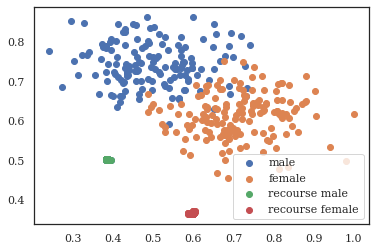

Current Centralization is 0.5
Current Atkinson is 0.9842668861352033
Current Avg Proxi Index is 0.7296526768610361
invalidation is 0.0
0.27498610586333505
0.26650045402275546
0.008485651840579589
(295, 4)
(295,)


In [10]:
hyperparams = {
    "data_name": dataset.name,
    "n_search_samples": 50,
    "p_norm": 2,
    "step": 1e-2,
    "max_iter": 2000,
    "clamp": False,
    "binary_cat_features": False,
    "vae_params": {
        "layers": [len(ml_model.feature_input_order)-len(immutable), 256, 128, 2],
        "train": True,
        "lambda_reg": 1e-6,
        "epochs": 1000,
        "lr": 1e-3,
        "batch_size": 32,
        "kl": 2
    },  
}
ar_model = CCHVAE(ml_model, hyperparams)

negative_instances = dataset.df_train[ml_model.predict(dataset.df_train)<0.5]
negative_instances.to_csv('./balance_data/syn_negative_instances.csv')
cf = ar_model.get_counterfactuals(negative_instances)
cf.index = negative_instances.index
sensitive = "sex_1"

import matplotlib.pyplot as plt
import copy 
current_population = copy.deepcopy(dataset.df_train)

cf = encode_constraint(cf, negative_instances, [sensitive])
current_population = copy.deepcopy(dataset.df_train)
current_population.loc[negative_instances.index,['x1','x2',sensitive]] = cf[['x1','x2',sensitive]].values
current_population = current_population.dropna()
plt.scatter(current_population.x1[current_population[sensitive]==1],current_population.x2[current_population[sensitive]==1],label='male')
plt.scatter(current_population.x1[current_population[sensitive]==0],current_population.x2[current_population[sensitive]==0],label='female')
temp1 = cf['x1'][negative_instances[sensitive]==1]
temp2 = cf['x2'][negative_instances[sensitive]==1]
# randomization for visual purpose 
noise = 0
plt.scatter(temp1 + np.random.uniform(size=len(temp1)) * noise,\
    temp2 + np.random.uniform(size=len(temp2)) * noise, label = 'recourse male')
temp1 = cf['x1'][negative_instances[sensitive]==0]
temp2 = cf['x2'][negative_instances[sensitive]==0]
plt.scatter(temp1 + np.random.uniform(size=len(temp1)) * noise,\
    temp2 + np.random.uniform(size=len(temp2)) * noise, label = 'recourse female')
plt.legend()
plt.show()
plt.savefig(f'./log/synfig/syn_cchvae_after.pdf')
plt.close()

features = ['x1','x2']
pred = (ml_model.predict(current_population) > 0.5).reshape(-1)
predprob = (ml_model.predict(current_population)).reshape(-1)
c_central, radius = centralization(current_population[sen_feature].values, \
    current_population[features].values, 
    radius
    )
print(f'Current Centralization is {c_central}')
c_atkinson = atkinson(current_population[sen_feature].values, \
    current_population[features].values, \
    origin_features = dataset.df_train[mutable_feature].values)
print(f'Current Atkinson is {c_atkinson}')
a = current_population
b = dataset.df_train
c_ap = avg_proximity2(a[sen_feature].values, \
    a[features].values)
print(f'Current Avg Proxi Index is {c_ap}')    

inv_rate = invalidation(cf, ml_model)
print(f'invalidation is {inv_rate}')
rec_cost = recourse_cost(negative_instances, cf)

negative_sens = negative_instances[sensitive]
rec_fair = fairness_cost(negative_instances, cf, negative_sens)

vynn = ynn(dataset.df[cf.columns], cf, ml_model, 5)
close = closeness(cf[mutable_feature], dataset.df[dataset.df.y==1][mutable_feature])
result = result.append({'metric':'centralization_after', \
    'value': c_central, 'method': 'CCHVAE'}, ignore_index = True)
result = result.append({'metric':'atkinson_after', \
    'value': c_atkinson, 'method': 'CCHVAE'}, ignore_index = True)
result = result.append({'metric':'avgproxi_after', \
    'value': c_ap, 'method': 'CCHVAE'}, ignore_index = True)

result = result.append({'metric':'inv_rate', \
    'value': inv_rate, 'method': 'CCHVAE'}, ignore_index = True)
result = result.append({ 'metric':'recourse_cost', \
    'value': rec_cost,  'method': 'CCHVAE'}, ignore_index = True)
result = result.append({ 'metric':'recourse_faircost', \
    'value': rec_fair,  'method': 'CCHVAE'}, ignore_index = True) 
result = result.append({ 'metric':'ynn', \
    'value': vynn,  'method': 'CCHVAE'}, ignore_index = True)             
result.value = result.value.astype(float)

In [11]:
result 

,metric,value,method
0,centralization_pre,0.493056,None
1,atkinson_pre,0.797725,None
2,avgproxi_pre,0.662624,None
3,centralization_after,0.500000,Watcher
4,atkinson_after,0.823536,Watcher
5,avgproxi_after,0.735595,Watcher
6,inv_rate,0.000000,Watcher
7,recourse_cost,0.296403,Watcher
8,recourse_faircost,0.015337,Watcher
9,ynn,0.649492,Watcher


# CRUD 

[INFO] Start training of CSVAE... [csvae.py fit]


  0%|          | 0/200 [00:00<?, ?it/s]

[INFO] epoch 0: x recon loss: 0.04929013766348362 [csvae.py fit]
[INFO] epoch 0: y recon loss: 26.446859664916992 [csvae.py fit]


  0%|          | 1/200 [00:00<01:11,  2.79it/s]

[INFO] epoch 1: x recon loss: 0.04030098736286163 [csvae.py fit]
[INFO] epoch 1: y recon loss: 26.978156242370606 [csvae.py fit]


  1%|          | 2/200 [00:00<01:08,  2.89it/s]

[INFO] epoch 2: x recon loss: 0.036686557034651436 [csvae.py fit]
[INFO] epoch 2: y recon loss: 26.809688644409178 [csvae.py fit]


  2%|▏         | 3/200 [00:01<01:12,  2.72it/s]

[INFO] epoch 3: x recon loss: 0.03459237528964877 [csvae.py fit]
[INFO] epoch 3: y recon loss: 26.803582153320313 [csvae.py fit]


  2%|▏         | 4/200 [00:01<01:19,  2.45it/s]

[INFO] epoch 4: x recon loss: 0.03340922211110592 [csvae.py fit]
[INFO] epoch 4: y recon loss: 26.76931948852539 [csvae.py fit]


  2%|▎         | 5/200 [00:01<01:09,  2.81it/s]

[INFO] epoch 5: x recon loss: 0.03195051986724138 [csvae.py fit]
[INFO] epoch 5: y recon loss: 26.735977770487466 [csvae.py fit]


  3%|▎         | 6/200 [00:02<01:01,  3.14it/s]

[INFO] epoch 6: x recon loss: 0.030619474346084256 [csvae.py fit]
[INFO] epoch 6: y recon loss: 26.71831417628697 [csvae.py fit]


  4%|▎         | 7/200 [00:02<01:00,  3.20it/s]

[INFO] epoch 7: x recon loss: 0.028856432950124144 [csvae.py fit]
[INFO] epoch 7: y recon loss: 26.690259246826173 [csvae.py fit]


  4%|▍         | 8/200 [00:02<01:08,  2.78it/s]

[INFO] epoch 8: x recon loss: 0.02688409690020813 [csvae.py fit]
[INFO] epoch 8: y recon loss: 26.68772541469998 [csvae.py fit]


  4%|▍         | 9/200 [00:03<01:10,  2.69it/s]

[INFO] epoch 9: x recon loss: 0.025049670098349453 [csvae.py fit]
[INFO] epoch 9: y recon loss: 26.684697143554686 [csvae.py fit]


  5%|▌         | 10/200 [00:03<01:07,  2.83it/s]

[INFO] epoch 10: x recon loss: 0.023341339785944333 [csvae.py fit]
[INFO] epoch 10: y recon loss: 26.672344367287376 [csvae.py fit]


  6%|▌         | 11/200 [00:03<01:00,  3.10it/s]

[INFO] epoch 11: x recon loss: 0.021890519578009845 [csvae.py fit]
[INFO] epoch 11: y recon loss: 26.66126034418742 [csvae.py fit]


  6%|▌         | 12/200 [00:04<00:57,  3.27it/s]

[INFO] epoch 12: x recon loss: 0.020715669561177492 [csvae.py fit]
[INFO] epoch 12: y recon loss: 26.647933197021484 [csvae.py fit]


  6%|▋         | 13/200 [00:04<00:55,  3.38it/s]

[INFO] epoch 13: x recon loss: 0.019672829368417816 [csvae.py fit]
[INFO] epoch 13: y recon loss: 26.64086879185268 [csvae.py fit]


  7%|▋         | 14/200 [00:04<00:53,  3.46it/s]

[INFO] epoch 14: x recon loss: 0.01877391028838853 [csvae.py fit]
[INFO] epoch 14: y recon loss: 26.64199889119466 [csvae.py fit]


  8%|▊         | 15/200 [00:04<00:53,  3.49it/s]

[INFO] epoch 15: x recon loss: 0.01797947097744327 [csvae.py fit]
[INFO] epoch 15: y recon loss: 26.639647245407104 [csvae.py fit]


  8%|▊         | 16/200 [00:05<00:51,  3.54it/s]

[INFO] epoch 16: x recon loss: 0.01730279359692598 [csvae.py fit]
[INFO] epoch 16: y recon loss: 26.63916405172909 [csvae.py fit]


  8%|▊         | 17/200 [00:05<00:51,  3.58it/s]

[INFO] epoch 17: x recon loss: 0.01665613426723414 [csvae.py fit]
[INFO] epoch 17: y recon loss: 26.639976959228516 [csvae.py fit]


  9%|▉         | 18/200 [00:05<00:51,  3.55it/s]

[INFO] epoch 18: x recon loss: 0.01607712469749937 [csvae.py fit]
[INFO] epoch 18: y recon loss: 26.631775962428044 [csvae.py fit]


 10%|▉         | 19/200 [00:06<00:51,  3.50it/s]

[INFO] epoch 19: x recon loss: 0.015578582265414297 [csvae.py fit]
[INFO] epoch 19: y recon loss: 26.628388217926027 [csvae.py fit]


 10%|█         | 20/200 [00:06<00:50,  3.58it/s]

[INFO] epoch 20: x recon loss: 0.01508828078307921 [csvae.py fit]
[INFO] epoch 20: y recon loss: 26.62631295703706 [csvae.py fit]


 10%|█         | 21/200 [00:06<00:48,  3.69it/s]

[INFO] epoch 21: x recon loss: 0.014651348225941713 [csvae.py fit]
[INFO] epoch 21: y recon loss: 26.63115536776456 [csvae.py fit]


 11%|█         | 22/200 [00:06<00:46,  3.86it/s]

[INFO] epoch 22: x recon loss: 0.014269319086781014 [csvae.py fit]
[INFO] epoch 22: y recon loss: 26.633063142195994 [csvae.py fit]


 12%|█▏        | 23/200 [00:06<00:42,  4.13it/s]

[INFO] epoch 23: x recon loss: 0.013917134857426088 [csvae.py fit]
[INFO] epoch 23: y recon loss: 26.64146609624227 [csvae.py fit]


 12%|█▏        | 24/200 [00:07<00:42,  4.13it/s]

[INFO] epoch 24: x recon loss: 0.013577025894075632 [csvae.py fit]
[INFO] epoch 24: y recon loss: 26.64044339904785 [csvae.py fit]


 12%|█▎        | 25/200 [00:07<00:41,  4.24it/s]

[INFO] epoch 25: x recon loss: 0.013282189880354473 [csvae.py fit]
[INFO] epoch 25: y recon loss: 26.64127137404222 [csvae.py fit]


 13%|█▎        | 26/200 [00:07<00:40,  4.32it/s]

[INFO] epoch 26: x recon loss: 0.013001335218065867 [csvae.py fit]
[INFO] epoch 26: y recon loss: 26.641473993372035 [csvae.py fit]


 14%|█▎        | 27/200 [00:07<00:41,  4.21it/s]

[INFO] epoch 27: x recon loss: 0.012739101099848216 [csvae.py fit]
[INFO] epoch 27: y recon loss: 26.638470769609725 [csvae.py fit]


 14%|█▍        | 28/200 [00:08<00:39,  4.31it/s]

[INFO] epoch 28: x recon loss: 0.012470642183746758 [csvae.py fit]
[INFO] epoch 28: y recon loss: 26.635043708538188 [csvae.py fit]


 14%|█▍        | 29/200 [00:08<00:40,  4.18it/s]

[INFO] epoch 29: x recon loss: 0.012237566038034857 [csvae.py fit]
[INFO] epoch 29: y recon loss: 26.63794533030192 [csvae.py fit]


 15%|█▌        | 30/200 [00:08<00:41,  4.13it/s]

[INFO] epoch 30: x recon loss: 0.012020325697357616 [csvae.py fit]
[INFO] epoch 30: y recon loss: 26.64139738267468 [csvae.py fit]


 16%|█▌        | 31/200 [00:08<00:41,  4.07it/s]

[INFO] epoch 31: x recon loss: 0.011803569423500448 [csvae.py fit]
[INFO] epoch 31: y recon loss: 26.642855916023255 [csvae.py fit]


 16%|█▌        | 32/200 [00:09<00:43,  3.87it/s]

[INFO] epoch 32: x recon loss: 0.01160051771975828 [csvae.py fit]
[INFO] epoch 32: y recon loss: 26.641340778235232 [csvae.py fit]


 16%|█▋        | 33/200 [00:09<00:46,  3.57it/s]

[INFO] epoch 33: x recon loss: 0.011416586634483845 [csvae.py fit]
[INFO] epoch 33: y recon loss: 26.642021771599264 [csvae.py fit]


 17%|█▋        | 34/200 [00:09<00:44,  3.70it/s]

[INFO] epoch 34: x recon loss: 0.01125174134570573 [csvae.py fit]
[INFO] epoch 34: y recon loss: 26.644430147443497 [csvae.py fit]


 18%|█▊        | 35/200 [00:09<00:43,  3.83it/s]

[INFO] epoch 35: x recon loss: 0.011103803483096676 [csvae.py fit]
[INFO] epoch 35: y recon loss: 26.645645429823134 [csvae.py fit]


 18%|█▊        | 36/200 [00:10<00:41,  3.97it/s]

[INFO] epoch 36: x recon loss: 0.010959587907670317 [csvae.py fit]
[INFO] epoch 36: y recon loss: 26.645615335412927 [csvae.py fit]


 18%|█▊        | 37/200 [00:10<00:41,  3.97it/s]

[INFO] epoch 37: x recon loss: 0.010818704352223952 [csvae.py fit]
[INFO] epoch 37: y recon loss: 26.646749954223633 [csvae.py fit]


 19%|█▉        | 38/200 [00:10<00:41,  3.90it/s]

[INFO] epoch 38: x recon loss: 0.010686213442673669 [csvae.py fit]
[INFO] epoch 38: y recon loss: 26.646829002575995 [csvae.py fit]


 20%|█▉        | 39/200 [00:10<00:41,  3.87it/s]

[INFO] epoch 39: x recon loss: 0.010555218879366293 [csvae.py fit]
[INFO] epoch 39: y recon loss: 26.64741015625 [csvae.py fit]


 20%|██        | 40/200 [00:11<00:39,  4.02it/s]

[INFO] epoch 40: x recon loss: 0.010424712822749847 [csvae.py fit]
[INFO] epoch 40: y recon loss: 26.648736760209246 [csvae.py fit]


 20%|██        | 41/200 [00:11<00:39,  4.05it/s]

[INFO] epoch 41: x recon loss: 0.010301950979046523 [csvae.py fit]
[INFO] epoch 41: y recon loss: 26.649405517578124 [csvae.py fit]


 21%|██        | 42/200 [00:11<00:39,  4.04it/s]

[INFO] epoch 42: x recon loss: 0.010191300513959209 [csvae.py fit]
[INFO] epoch 42: y recon loss: 26.648872043698333 [csvae.py fit]


 22%|██▏       | 43/200 [00:11<00:39,  3.97it/s]

[INFO] epoch 43: x recon loss: 0.010077082471583378 [csvae.py fit]
[INFO] epoch 43: y recon loss: 26.651152272657914 [csvae.py fit]


 22%|██▏       | 44/200 [00:12<00:39,  3.98it/s]

[INFO] epoch 44: x recon loss: 0.009964522219366497 [csvae.py fit]
[INFO] epoch 44: y recon loss: 26.651624264187284 [csvae.py fit]


 22%|██▎       | 45/200 [00:12<00:39,  3.96it/s]

[INFO] epoch 45: x recon loss: 0.009859151355314838 [csvae.py fit]
[INFO] epoch 45: y recon loss: 26.64894953354545 [csvae.py fit]


 23%|██▎       | 46/200 [00:12<00:39,  3.93it/s]

[INFO] epoch 46: x recon loss: 0.009756846569002943 [csvae.py fit]
[INFO] epoch 46: y recon loss: 26.651199197972076 [csvae.py fit]


 24%|██▎       | 47/200 [00:12<00:38,  3.95it/s]

[INFO] epoch 47: x recon loss: 0.009663182069586279 [csvae.py fit]
[INFO] epoch 47: y recon loss: 26.652765661875407 [csvae.py fit]


 24%|██▍       | 48/200 [00:13<00:38,  3.98it/s]

[INFO] epoch 48: x recon loss: 0.009571877704857259 [csvae.py fit]
[INFO] epoch 48: y recon loss: 26.651996176583427 [csvae.py fit]


 24%|██▍       | 49/200 [00:13<00:37,  3.98it/s]

[INFO] epoch 49: x recon loss: 0.009486281793564559 [csvae.py fit]
[INFO] epoch 49: y recon loss: 26.650317520141602 [csvae.py fit]


 25%|██▌       | 50/200 [00:13<00:37,  4.00it/s]

[INFO] epoch 50: x recon loss: 0.00940025100539274 [csvae.py fit]
[INFO] epoch 50: y recon loss: 26.650660222371418 [csvae.py fit]


 26%|██▌       | 51/200 [00:13<00:36,  4.03it/s]

[INFO] epoch 51: x recon loss: 0.009315731307993142 [csvae.py fit]
[INFO] epoch 51: y recon loss: 26.65027976843027 [csvae.py fit]


 26%|██▌       | 52/200 [00:14<00:37,  3.93it/s]

[INFO] epoch 52: x recon loss: 0.009236292648217025 [csvae.py fit]
[INFO] epoch 52: y recon loss: 26.650436218549622 [csvae.py fit]


 26%|██▋       | 53/200 [00:14<00:37,  3.96it/s]

[INFO] epoch 53: x recon loss: 0.00915849586431351 [csvae.py fit]
[INFO] epoch 53: y recon loss: 26.650228455154984 [csvae.py fit]


 27%|██▋       | 54/200 [00:14<00:37,  3.93it/s]

[INFO] epoch 54: x recon loss: 0.009091605978425253 [csvae.py fit]
[INFO] epoch 54: y recon loss: 26.65191743330522 [csvae.py fit]


 28%|██▊       | 55/200 [00:15<00:37,  3.86it/s]

[INFO] epoch 55: x recon loss: 0.009023727888041842 [csvae.py fit]
[INFO] epoch 55: y recon loss: 26.651433259419033 [csvae.py fit]


 28%|██▊       | 56/200 [00:15<00:37,  3.83it/s]

[INFO] epoch 56: x recon loss: 0.008957603695851407 [csvae.py fit]
[INFO] epoch 56: y recon loss: 26.650798812330816 [csvae.py fit]


 28%|██▊       | 57/200 [00:15<00:36,  3.89it/s]

[INFO] epoch 57: x recon loss: 0.008888636597689112 [csvae.py fit]
[INFO] epoch 57: y recon loss: 26.650224917181607 [csvae.py fit]


 29%|██▉       | 58/200 [00:15<00:36,  3.94it/s]

[INFO] epoch 58: x recon loss: 0.008824279023239673 [csvae.py fit]
[INFO] epoch 58: y recon loss: 26.650792847972806 [csvae.py fit]


 30%|██▉       | 59/200 [00:16<00:35,  4.01it/s]

[INFO] epoch 59: x recon loss: 0.008757650633032124 [csvae.py fit]
[INFO] epoch 59: y recon loss: 26.650771773020427 [csvae.py fit]


 30%|███       | 60/200 [00:16<00:34,  4.06it/s]

[INFO] epoch 60: x recon loss: 0.008693440340489881 [csvae.py fit]
[INFO] epoch 60: y recon loss: 26.65117281053887 [csvae.py fit]


 30%|███       | 61/200 [00:16<00:33,  4.09it/s]

[INFO] epoch 61: x recon loss: 0.008635150888003408 [csvae.py fit]
[INFO] epoch 61: y recon loss: 26.652061731892246 [csvae.py fit]


 31%|███       | 62/200 [00:16<00:33,  4.11it/s]

[INFO] epoch 62: x recon loss: 0.008597849107805698 [csvae.py fit]
[INFO] epoch 62: y recon loss: 26.65376420157296 [csvae.py fit]


 32%|███▏      | 63/200 [00:16<00:33,  4.14it/s]

[INFO] epoch 63: x recon loss: 0.008552507843851344 [csvae.py fit]
[INFO] epoch 63: y recon loss: 26.653304561376572 [csvae.py fit]


 32%|███▏      | 64/200 [00:17<00:32,  4.16it/s]

[INFO] epoch 64: x recon loss: 0.008498045599661195 [csvae.py fit]
[INFO] epoch 64: y recon loss: 26.65399423100398 [csvae.py fit]


 32%|███▎      | 65/200 [00:17<00:32,  4.11it/s]

[INFO] epoch 65: x recon loss: 0.008444169555706057 [csvae.py fit]
[INFO] epoch 65: y recon loss: 26.65283912080707 [csvae.py fit]


 33%|███▎      | 66/200 [00:17<00:32,  4.10it/s]

[INFO] epoch 66: x recon loss: 0.008392231416985838 [csvae.py fit]
[INFO] epoch 66: y recon loss: 26.654110899967932 [csvae.py fit]


 34%|███▎      | 67/200 [00:17<00:33,  3.99it/s]

[INFO] epoch 67: x recon loss: 0.008343013784135966 [csvae.py fit]
[INFO] epoch 67: y recon loss: 26.653721146303063 [csvae.py fit]


 34%|███▍      | 68/200 [00:18<00:33,  3.89it/s]

[INFO] epoch 68: x recon loss: 0.008290908521554176 [csvae.py fit]
[INFO] epoch 68: y recon loss: 26.653696673849353 [csvae.py fit]


 34%|███▍      | 69/200 [00:18<00:32,  4.09it/s]

[INFO] epoch 69: x recon loss: 0.008245527583174407 [csvae.py fit]
[INFO] epoch 69: y recon loss: 26.65308303615025 [csvae.py fit]


 35%|███▌      | 70/200 [00:18<00:33,  3.86it/s]

[INFO] epoch 70: x recon loss: 0.008201588915634743 [csvae.py fit]
[INFO] epoch 70: y recon loss: 26.65381837549344 [csvae.py fit]


 36%|███▌      | 71/200 [00:18<00:32,  3.97it/s]

[INFO] epoch 71: x recon loss: 0.00816300241729348 [csvae.py fit]
[INFO] epoch 71: y recon loss: 26.654391729566786 [csvae.py fit]


 36%|███▌      | 72/200 [00:19<00:31,  4.08it/s]

[INFO] epoch 72: x recon loss: 0.00811966363531984 [csvae.py fit]
[INFO] epoch 72: y recon loss: 26.65365620025217 [csvae.py fit]


 36%|███▋      | 73/200 [00:19<00:30,  4.12it/s]

[INFO] epoch 73: x recon loss: 0.00807515535994458 [csvae.py fit]
[INFO] epoch 73: y recon loss: 26.654479712408943 [csvae.py fit]


 37%|███▋      | 74/200 [00:19<00:30,  4.15it/s]

[INFO] epoch 74: x recon loss: 0.00803053546945254 [csvae.py fit]
[INFO] epoch 74: y recon loss: 26.65495863647461 [csvae.py fit]


 38%|███▊      | 75/200 [00:19<00:31,  3.94it/s]

[INFO] epoch 75: x recon loss: 0.007987911793967023 [csvae.py fit]
[INFO] epoch 75: y recon loss: 26.655526219418174 [csvae.py fit]


 38%|███▊      | 76/200 [00:20<00:31,  4.00it/s]

[INFO] epoch 76: x recon loss: 0.007948119353212706 [csvae.py fit]
[INFO] epoch 76: y recon loss: 26.65572643924069 [csvae.py fit]


 38%|███▊      | 77/200 [00:20<00:30,  4.09it/s]

[INFO] epoch 77: x recon loss: 0.007907268949306738 [csvae.py fit]
[INFO] epoch 77: y recon loss: 26.65524311359112 [csvae.py fit]


 39%|███▉      | 78/200 [00:20<00:30,  4.05it/s]

[INFO] epoch 78: x recon loss: 0.007869211756801114 [csvae.py fit]
[INFO] epoch 78: y recon loss: 26.65554178648357 [csvae.py fit]


 40%|███▉      | 79/200 [00:21<00:33,  3.65it/s]

[INFO] epoch 79: x recon loss: 0.007833314606570638 [csvae.py fit]
[INFO] epoch 79: y recon loss: 26.655499863624573 [csvae.py fit]


 40%|████      | 80/200 [00:21<00:31,  3.84it/s]

[INFO] epoch 80: x recon loss: 0.007794213060887507 [csvae.py fit]
[INFO] epoch 80: y recon loss: 26.65611751226731 [csvae.py fit]


 40%|████      | 81/200 [00:21<00:33,  3.53it/s]

[INFO] epoch 81: x recon loss: 0.007757438494846588 [csvae.py fit]
[INFO] epoch 81: y recon loss: 26.656153837064416 [csvae.py fit]


 41%|████      | 82/200 [00:21<00:35,  3.35it/s]

[INFO] epoch 82: x recon loss: 0.007723026155348284 [csvae.py fit]
[INFO] epoch 82: y recon loss: 26.656173868753825 [csvae.py fit]


 42%|████▏     | 83/200 [00:22<00:32,  3.59it/s]

[INFO] epoch 83: x recon loss: 0.0076887068758896065 [csvae.py fit]
[INFO] epoch 83: y recon loss: 26.656991192953928 [csvae.py fit]


 42%|████▏     | 84/200 [00:22<00:31,  3.73it/s]

[INFO] epoch 84: x recon loss: 0.0076559003491831175 [csvae.py fit]
[INFO] epoch 84: y recon loss: 26.656287043851965 [csvae.py fit]


 42%|████▎     | 85/200 [00:22<00:33,  3.45it/s]

[INFO] epoch 85: x recon loss: 0.007621511806798882 [csvae.py fit]
[INFO] epoch 85: y recon loss: 26.657387126656467 [csvae.py fit]


 43%|████▎     | 86/200 [00:22<00:31,  3.67it/s]

[INFO] epoch 86: x recon loss: 0.007588218164833627 [csvae.py fit]
[INFO] epoch 86: y recon loss: 26.657443659990683 [csvae.py fit]


 44%|████▎     | 87/200 [00:23<00:29,  3.81it/s]

[INFO] epoch 87: x recon loss: 0.007557451609860767 [csvae.py fit]
[INFO] epoch 87: y recon loss: 26.65806198640303 [csvae.py fit]


 44%|████▍     | 88/200 [00:23<00:28,  3.98it/s]

[INFO] epoch 88: x recon loss: 0.007531664565917146 [csvae.py fit]
[INFO] epoch 88: y recon loss: 26.658146323729095 [csvae.py fit]


 44%|████▍     | 89/200 [00:23<00:27,  4.06it/s]

[INFO] epoch 89: x recon loss: 0.007500644915944172 [csvae.py fit]
[INFO] epoch 89: y recon loss: 26.65869298892551 [csvae.py fit]


 45%|████▌     | 90/200 [00:23<00:26,  4.13it/s]

[INFO] epoch 90: x recon loss: 0.007470095334779266 [csvae.py fit]
[INFO] epoch 90: y recon loss: 26.65909895676833 [csvae.py fit]


 46%|████▌     | 91/200 [00:24<00:26,  4.15it/s]

[INFO] epoch 91: x recon loss: 0.0074402993307044 [csvae.py fit]
[INFO] epoch 91: y recon loss: 26.659353064661442 [csvae.py fit]


 46%|████▌     | 92/200 [00:24<00:26,  4.14it/s]

[INFO] epoch 92: x recon loss: 0.007410320229327647 [csvae.py fit]
[INFO] epoch 92: y recon loss: 26.659441166539345 [csvae.py fit]


 46%|████▋     | 93/200 [00:24<00:25,  4.17it/s]

[INFO] epoch 93: x recon loss: 0.007382636137326506 [csvae.py fit]
[INFO] epoch 93: y recon loss: 26.659636350591132 [csvae.py fit]


 47%|████▋     | 94/200 [00:24<00:25,  4.16it/s]

[INFO] epoch 94: x recon loss: 0.007353654745770128 [csvae.py fit]
[INFO] epoch 94: y recon loss: 26.659752828497634 [csvae.py fit]


 48%|████▊     | 95/200 [00:25<00:25,  4.17it/s]

[INFO] epoch 95: x recon loss: 0.007323958705819677 [csvae.py fit]
[INFO] epoch 95: y recon loss: 26.659700535138448 [csvae.py fit]


 48%|████▊     | 96/200 [00:25<00:25,  4.15it/s]

[INFO] epoch 96: x recon loss: 0.007297368954732707 [csvae.py fit]
[INFO] epoch 96: y recon loss: 26.659470385521956 [csvae.py fit]


 48%|████▊     | 97/200 [00:25<00:27,  3.79it/s]

[INFO] epoch 97: x recon loss: 0.007271707785619917 [csvae.py fit]
[INFO] epoch 97: y recon loss: 26.65939712680116 [csvae.py fit]


 49%|████▉     | 98/200 [00:25<00:26,  3.90it/s]

[INFO] epoch 98: x recon loss: 0.0072452601311596655 [csvae.py fit]
[INFO] epoch 98: y recon loss: 26.659411840727834 [csvae.py fit]


 50%|████▉     | 99/200 [00:26<00:25,  3.98it/s]

[INFO] epoch 99: x recon loss: 0.007220584160462022 [csvae.py fit]
[INFO] epoch 99: y recon loss: 26.659395667266846 [csvae.py fit]


 50%|█████     | 100/200 [00:26<00:24,  4.03it/s]

[INFO] epoch 100: x recon loss: 0.007197600438139669 [csvae.py fit]
[INFO] epoch 100: y recon loss: 26.659305046006004 [csvae.py fit]


 50%|█████     | 101/200 [00:26<00:27,  3.57it/s]

[INFO] epoch 101: x recon loss: 0.007174920670907287 [csvae.py fit]
[INFO] epoch 101: y recon loss: 26.659393407036276 [csvae.py fit]


 51%|█████     | 102/200 [00:26<00:26,  3.75it/s]

[INFO] epoch 102: x recon loss: 0.007148802703590069 [csvae.py fit]
[INFO] epoch 102: y recon loss: 26.659699775177298 [csvae.py fit]


 52%|█████▏    | 103/200 [00:27<00:25,  3.87it/s]

[INFO] epoch 103: x recon loss: 0.007123077775691994 [csvae.py fit]
[INFO] epoch 103: y recon loss: 26.65984798651475 [csvae.py fit]


 52%|█████▏    | 104/200 [00:27<00:24,  3.94it/s]

[INFO] epoch 104: x recon loss: 0.007100256239019689 [csvae.py fit]
[INFO] epoch 104: y recon loss: 26.659855057489306 [csvae.py fit]


 52%|█████▎    | 105/200 [00:27<00:23,  3.99it/s]

[INFO] epoch 105: x recon loss: 0.0070775045210249585 [csvae.py fit]
[INFO] epoch 105: y recon loss: 26.660292366315733 [csvae.py fit]


 53%|█████▎    | 106/200 [00:27<00:23,  4.04it/s]

[INFO] epoch 106: x recon loss: 0.007055031101732889 [csvae.py fit]
[INFO] epoch 106: y recon loss: 26.660345585903276 [csvae.py fit]


 54%|█████▎    | 107/200 [00:28<00:22,  4.12it/s]

[INFO] epoch 107: x recon loss: 0.007034491508060859 [csvae.py fit]
[INFO] epoch 107: y recon loss: 26.660451662275527 [csvae.py fit]


 54%|█████▍    | 108/200 [00:28<00:22,  4.17it/s]

[INFO] epoch 108: x recon loss: 0.007012031133448996 [csvae.py fit]
[INFO] epoch 108: y recon loss: 26.66040173941796 [csvae.py fit]


 55%|█████▍    | 109/200 [00:28<00:21,  4.19it/s]

[INFO] epoch 109: x recon loss: 0.006989913920363919 [csvae.py fit]
[INFO] epoch 109: y recon loss: 26.66050392775102 [csvae.py fit]


 55%|█████▌    | 110/200 [00:28<00:21,  4.22it/s]

[INFO] epoch 110: x recon loss: 0.006969537546287652 [csvae.py fit]
[INFO] epoch 110: y recon loss: 26.660697452442065 [csvae.py fit]


 56%|█████▌    | 111/200 [00:29<00:20,  4.25it/s]

[INFO] epoch 111: x recon loss: 0.006948857817083731 [csvae.py fit]
[INFO] epoch 111: y recon loss: 26.66052172592708 [csvae.py fit]


 56%|█████▌    | 112/200 [00:29<00:20,  4.20it/s]

[INFO] epoch 112: x recon loss: 0.006928198762831435 [csvae.py fit]
[INFO] epoch 112: y recon loss: 26.660582523852323 [csvae.py fit]


 56%|█████▋    | 113/200 [00:29<00:20,  4.23it/s]

[INFO] epoch 113: x recon loss: 0.006909100864850508 [csvae.py fit]
[INFO] epoch 113: y recon loss: 26.660731401945416 [csvae.py fit]


 57%|█████▋    | 114/200 [00:29<00:20,  4.28it/s]

[INFO] epoch 114: x recon loss: 0.006889830917200964 [csvae.py fit]
[INFO] epoch 114: y recon loss: 26.660957822716753 [csvae.py fit]


 57%|█████▊    | 115/200 [00:30<00:19,  4.30it/s]

[INFO] epoch 115: x recon loss: 0.006870216279258502 [csvae.py fit]
[INFO] epoch 115: y recon loss: 26.66077557793979 [csvae.py fit]


 58%|█████▊    | 116/200 [00:30<00:22,  3.77it/s]

[INFO] epoch 116: x recon loss: 0.006850283629316677 [csvae.py fit]
[INFO] epoch 116: y recon loss: 26.660854856050932 [csvae.py fit]


 58%|█████▊    | 117/200 [00:30<00:21,  3.85it/s]

[INFO] epoch 117: x recon loss: 0.006831128643352096 [csvae.py fit]
[INFO] epoch 117: y recon loss: 26.661105344093453 [csvae.py fit]


 59%|█████▉    | 118/200 [00:30<00:20,  3.93it/s]

[INFO] epoch 118: x recon loss: 0.006811254429435279 [csvae.py fit]
[INFO] epoch 118: y recon loss: 26.660756257642216 [csvae.py fit]


 60%|█████▉    | 119/200 [00:31<00:20,  4.03it/s]

[INFO] epoch 119: x recon loss: 0.006793763030630847 [csvae.py fit]
[INFO] epoch 119: y recon loss: 26.660843350728353 [csvae.py fit]


 60%|██████    | 120/200 [00:31<00:21,  3.64it/s]

[INFO] epoch 120: x recon loss: 0.006776791627187867 [csvae.py fit]
[INFO] epoch 120: y recon loss: 26.66110896465207 [csvae.py fit]


 60%|██████    | 121/200 [00:31<00:20,  3.83it/s]

[INFO] epoch 121: x recon loss: 0.006759390659386018 [csvae.py fit]
[INFO] epoch 121: y recon loss: 26.66097074790079 [csvae.py fit]


 61%|██████    | 122/200 [00:31<00:19,  3.95it/s]

[INFO] epoch 122: x recon loss: 0.006743304274476519 [csvae.py fit]
[INFO] epoch 122: y recon loss: 26.661070397849976 [csvae.py fit]


 62%|██████▏   | 123/200 [00:32<00:19,  4.00it/s]

[INFO] epoch 123: x recon loss: 0.006725159831675551 [csvae.py fit]
[INFO] epoch 123: y recon loss: 26.660983916867163 [csvae.py fit]


 62%|██████▏   | 124/200 [00:32<00:21,  3.52it/s]

[INFO] epoch 124: x recon loss: 0.0067079921400547025 [csvae.py fit]
[INFO] epoch 124: y recon loss: 26.661378247070314 [csvae.py fit]


 62%|██████▎   | 125/200 [00:32<00:23,  3.24it/s]

[INFO] epoch 125: x recon loss: 0.006692563602331257 [csvae.py fit]
[INFO] epoch 125: y recon loss: 26.66127562931606 [csvae.py fit]


 63%|██████▎   | 126/200 [00:33<00:24,  3.08it/s]

[INFO] epoch 126: x recon loss: 0.006677190265654931 [csvae.py fit]
[INFO] epoch 126: y recon loss: 26.661389321755237 [csvae.py fit]


 64%|██████▎   | 127/200 [00:33<00:24,  2.96it/s]

[INFO] epoch 127: x recon loss: 0.006660869068582542 [csvae.py fit]
[INFO] epoch 127: y recon loss: 26.66157662153244 [csvae.py fit]


 64%|██████▍   | 128/200 [00:33<00:24,  2.92it/s]

[INFO] epoch 128: x recon loss: 0.006647641289574924 [csvae.py fit]
[INFO] epoch 128: y recon loss: 26.66150391216426 [csvae.py fit]


 64%|██████▍   | 129/200 [00:34<00:24,  2.91it/s]

[INFO] epoch 129: x recon loss: 0.006632612032529253 [csvae.py fit]
[INFO] epoch 129: y recon loss: 26.661389330350435 [csvae.py fit]


 65%|██████▌   | 130/200 [00:34<00:24,  2.89it/s]

[INFO] epoch 130: x recon loss: 0.0066167505454442655 [csvae.py fit]
[INFO] epoch 130: y recon loss: 26.661352399287335 [csvae.py fit]


 66%|██████▌   | 131/200 [00:35<00:23,  2.89it/s]

[INFO] epoch 131: x recon loss: 0.006604703165463764 [csvae.py fit]
[INFO] epoch 131: y recon loss: 26.661735851981422 [csvae.py fit]


 66%|██████▌   | 132/200 [00:35<00:23,  2.89it/s]

[INFO] epoch 132: x recon loss: 0.0065907391751031 [csvae.py fit]
[INFO] epoch 132: y recon loss: 26.662115300113992 [csvae.py fit]


 66%|██████▋   | 133/200 [00:35<00:23,  2.88it/s]

[INFO] epoch 133: x recon loss: 0.006576506727194386 [csvae.py fit]
[INFO] epoch 133: y recon loss: 26.662462773678907 [csvae.py fit]


 67%|██████▋   | 134/200 [00:36<00:23,  2.82it/s]

[INFO] epoch 134: x recon loss: 0.0065614250762457095 [csvae.py fit]
[INFO] epoch 134: y recon loss: 26.662330151028105 [csvae.py fit]


 68%|██████▊   | 135/200 [00:36<00:23,  2.77it/s]

[INFO] epoch 135: x recon loss: 0.0065474150363383265 [csvae.py fit]
[INFO] epoch 135: y recon loss: 26.662465700261734 [csvae.py fit]


 68%|██████▊   | 136/200 [00:36<00:23,  2.74it/s]

[INFO] epoch 136: x recon loss: 0.006535016898963139 [csvae.py fit]
[INFO] epoch 136: y recon loss: 26.662548377044008 [csvae.py fit]


 68%|██████▊   | 137/200 [00:37<00:20,  3.01it/s]

[INFO] epoch 137: x recon loss: 0.006522189659552406 [csvae.py fit]
[INFO] epoch 137: y recon loss: 26.662695614358654 [csvae.py fit]


 69%|██████▉   | 138/200 [00:37<00:19,  3.23it/s]

[INFO] epoch 138: x recon loss: 0.0065082557622021696 [csvae.py fit]
[INFO] epoch 138: y recon loss: 26.6626235116643 [csvae.py fit]


 70%|██████▉   | 139/200 [00:37<00:17,  3.41it/s]

[INFO] epoch 139: x recon loss: 0.00649569191397833 [csvae.py fit]
[INFO] epoch 139: y recon loss: 26.662372483934675 [csvae.py fit]


 70%|███████   | 140/200 [00:37<00:16,  3.55it/s]

[INFO] epoch 140: x recon loss: 0.006482769667851269 [csvae.py fit]
[INFO] epoch 140: y recon loss: 26.6624854240688 [csvae.py fit]


 70%|███████   | 141/200 [00:38<00:16,  3.65it/s]

[INFO] epoch 141: x recon loss: 0.006469568639705089 [csvae.py fit]
[INFO] epoch 141: y recon loss: 26.662559356689453 [csvae.py fit]


 71%|███████   | 142/200 [00:38<00:15,  3.72it/s]

[INFO] epoch 142: x recon loss: 0.006456726522451931 [csvae.py fit]
[INFO] epoch 142: y recon loss: 26.662717936055643 [csvae.py fit]


 72%|███████▏  | 143/200 [00:38<00:15,  3.77it/s]

[INFO] epoch 143: x recon loss: 0.006444568130795637 [csvae.py fit]
[INFO] epoch 143: y recon loss: 26.66274812274509 [csvae.py fit]


 72%|███████▏  | 144/200 [00:38<00:14,  3.81it/s]

[INFO] epoch 144: x recon loss: 0.006432336658945885 [csvae.py fit]
[INFO] epoch 144: y recon loss: 26.6630125111547 [csvae.py fit]


 72%|███████▎  | 145/200 [00:39<00:14,  3.80it/s]

[INFO] epoch 145: x recon loss: 0.006419676922210684 [csvae.py fit]
[INFO] epoch 145: y recon loss: 26.662749304575463 [csvae.py fit]


 73%|███████▎  | 146/200 [00:39<00:14,  3.83it/s]

[INFO] epoch 146: x recon loss: 0.006406860915677888 [csvae.py fit]
[INFO] epoch 146: y recon loss: 26.662780138392026 [csvae.py fit]


 74%|███████▎  | 147/200 [00:39<00:13,  3.83it/s]

[INFO] epoch 147: x recon loss: 0.006394388505345764 [csvae.py fit]
[INFO] epoch 147: y recon loss: 26.66288489315961 [csvae.py fit]


 74%|███████▍  | 148/200 [00:39<00:13,  3.89it/s]

[INFO] epoch 148: x recon loss: 0.006385625340857062 [csvae.py fit]
[INFO] epoch 148: y recon loss: 26.662823173471747 [csvae.py fit]


 74%|███████▍  | 149/200 [00:40<00:12,  3.96it/s]

[INFO] epoch 149: x recon loss: 0.006375385051158567 [csvae.py fit]
[INFO] epoch 149: y recon loss: 26.662656565856935 [csvae.py fit]


 75%|███████▌  | 150/200 [00:40<00:13,  3.80it/s]

[INFO] epoch 150: x recon loss: 0.006365015782008799 [csvae.py fit]
[INFO] epoch 150: y recon loss: 26.662657453524357 [csvae.py fit]


 76%|███████▌  | 151/200 [00:40<00:12,  3.87it/s]

[INFO] epoch 151: x recon loss: 0.006352416154328047 [csvae.py fit]
[INFO] epoch 151: y recon loss: 26.662989366430985 [csvae.py fit]


 76%|███████▌  | 152/200 [00:41<00:13,  3.45it/s]

[INFO] epoch 152: x recon loss: 0.006340906556720048 [csvae.py fit]
[INFO] epoch 152: y recon loss: 26.662801924562142 [csvae.py fit]


 76%|███████▋  | 153/200 [00:41<00:13,  3.60it/s]

[INFO] epoch 153: x recon loss: 0.00633067923241186 [csvae.py fit]
[INFO] epoch 153: y recon loss: 26.662908707160454 [csvae.py fit]


 77%|███████▋  | 154/200 [00:41<00:12,  3.71it/s]

[INFO] epoch 154: x recon loss: 0.006319339627820638 [csvae.py fit]
[INFO] epoch 154: y recon loss: 26.663363218738187 [csvae.py fit]


 78%|███████▊  | 155/200 [00:41<00:11,  3.81it/s]

[INFO] epoch 155: x recon loss: 0.006308859328213984 [csvae.py fit]
[INFO] epoch 155: y recon loss: 26.663268031095846 [csvae.py fit]


 78%|███████▊  | 156/200 [00:42<00:11,  3.88it/s]

[INFO] epoch 156: x recon loss: 0.006297863170291018 [csvae.py fit]
[INFO] epoch 156: y recon loss: 26.6633015825794 [csvae.py fit]


 78%|███████▊  | 157/200 [00:42<00:10,  3.94it/s]

[INFO] epoch 157: x recon loss: 0.0062871193127187934 [csvae.py fit]
[INFO] epoch 157: y recon loss: 26.663026871500136 [csvae.py fit]


 79%|███████▉  | 158/200 [00:42<00:10,  3.98it/s]

[INFO] epoch 158: x recon loss: 0.006277273158197227 [csvae.py fit]
[INFO] epoch 158: y recon loss: 26.662913778053138 [csvae.py fit]


 80%|███████▉  | 159/200 [00:42<00:10,  3.85it/s]

[INFO] epoch 159: x recon loss: 0.006265760286943987 [csvae.py fit]
[INFO] epoch 159: y recon loss: 26.663110988140104 [csvae.py fit]


 80%|████████  | 160/200 [00:43<00:10,  3.90it/s]

[INFO] epoch 160: x recon loss: 0.006255843814936762 [csvae.py fit]
[INFO] epoch 160: y recon loss: 26.6626983798957 [csvae.py fit]


 80%|████████  | 161/200 [00:43<00:09,  3.97it/s]

[INFO] epoch 161: x recon loss: 0.0062468869185052164 [csvae.py fit]
[INFO] epoch 161: y recon loss: 26.662921036143363 [csvae.py fit]


 81%|████████  | 162/200 [00:43<00:09,  3.96it/s]

[INFO] epoch 162: x recon loss: 0.006237291904006359 [csvae.py fit]
[INFO] epoch 162: y recon loss: 26.662660309493177 [csvae.py fit]


 82%|████████▏ | 163/200 [00:43<00:09,  4.00it/s]

[INFO] epoch 163: x recon loss: 0.006226792125110855 [csvae.py fit]
[INFO] epoch 163: y recon loss: 26.662698612213134 [csvae.py fit]


 82%|████████▏ | 164/200 [00:44<00:08,  4.06it/s]

[INFO] epoch 164: x recon loss: 0.006215565381684538 [csvae.py fit]
[INFO] epoch 164: y recon loss: 26.663118101177794 [csvae.py fit]


 82%|████████▎ | 165/200 [00:44<00:08,  4.09it/s]

[INFO] epoch 165: x recon loss: 0.006204918591215847 [csvae.py fit]
[INFO] epoch 165: y recon loss: 26.6629402266353 [csvae.py fit]


 83%|████████▎ | 166/200 [00:44<00:08,  4.12it/s]

[INFO] epoch 166: x recon loss: 0.006196015613867405 [csvae.py fit]
[INFO] epoch 166: y recon loss: 26.663030866520135 [csvae.py fit]


 84%|████████▎ | 167/200 [00:44<00:07,  4.14it/s]

[INFO] epoch 167: x recon loss: 0.006186008932501344 [csvae.py fit]
[INFO] epoch 167: y recon loss: 26.662960015251524 [csvae.py fit]


 84%|████████▍ | 168/200 [00:45<00:07,  4.17it/s]

[INFO] epoch 168: x recon loss: 0.006175933693750546 [csvae.py fit]
[INFO] epoch 168: y recon loss: 26.663276233560236 [csvae.py fit]


 84%|████████▍ | 169/200 [00:45<00:07,  4.17it/s]

[INFO] epoch 169: x recon loss: 0.006166050102123443 [csvae.py fit]
[INFO] epoch 169: y recon loss: 26.66315852176442 [csvae.py fit]


 85%|████████▌ | 170/200 [00:45<00:07,  4.17it/s]

[INFO] epoch 170: x recon loss: 0.006155611987154909 [csvae.py fit]
[INFO] epoch 170: y recon loss: 26.663157301785652 [csvae.py fit]


 86%|████████▌ | 171/200 [00:45<00:07,  3.85it/s]

[INFO] epoch 171: x recon loss: 0.00614580717349295 [csvae.py fit]
[INFO] epoch 171: y recon loss: 26.66335034348244 [csvae.py fit]


 86%|████████▌ | 172/200 [00:46<00:07,  3.94it/s]

[INFO] epoch 172: x recon loss: 0.006136121339611494 [csvae.py fit]
[INFO] epoch 172: y recon loss: 26.66331368727491 [csvae.py fit]


 86%|████████▋ | 173/200 [00:46<00:06,  4.02it/s]

[INFO] epoch 173: x recon loss: 0.006127217763542444 [csvae.py fit]
[INFO] epoch 173: y recon loss: 26.663104558484306 [csvae.py fit]


 87%|████████▋ | 174/200 [00:46<00:06,  4.07it/s]

[INFO] epoch 174: x recon loss: 0.006118319158894675 [csvae.py fit]
[INFO] epoch 174: y recon loss: 26.663016305106026 [csvae.py fit]


 88%|████████▊ | 175/200 [00:46<00:06,  4.11it/s]

[INFO] epoch 175: x recon loss: 0.0061086987320397215 [csvae.py fit]
[INFO] epoch 175: y recon loss: 26.663354226892643 [csvae.py fit]


 88%|████████▊ | 176/200 [00:46<00:05,  4.14it/s]

[INFO] epoch 176: x recon loss: 0.0060993316962178485 [csvae.py fit]
[INFO] epoch 176: y recon loss: 26.663089203915355 [csvae.py fit]


 88%|████████▊ | 177/200 [00:47<00:05,  4.16it/s]

[INFO] epoch 177: x recon loss: 0.006090873395657857 [csvae.py fit]
[INFO] epoch 177: y recon loss: 26.663112206619775 [csvae.py fit]


 89%|████████▉ | 178/200 [00:47<00:05,  4.17it/s]

[INFO] epoch 178: x recon loss: 0.006083237439831042 [csvae.py fit]
[INFO] epoch 178: y recon loss: 26.663025530596684 [csvae.py fit]


 90%|████████▉ | 179/200 [00:47<00:05,  4.16it/s]

[INFO] epoch 179: x recon loss: 0.00607478203655531 [csvae.py fit]
[INFO] epoch 179: y recon loss: 26.66304236984253 [csvae.py fit]


 90%|█████████ | 180/200 [00:47<00:04,  4.15it/s]

[INFO] epoch 180: x recon loss: 0.006066889328398428 [csvae.py fit]
[INFO] epoch 180: y recon loss: 26.662915599253953 [csvae.py fit]


 90%|█████████ | 181/200 [00:48<00:04,  4.13it/s]

[INFO] epoch 181: x recon loss: 0.006058341726650494 [csvae.py fit]
[INFO] epoch 181: y recon loss: 26.662860475058086 [csvae.py fit]


 91%|█████████ | 182/200 [00:48<00:04,  4.11it/s]

[INFO] epoch 182: x recon loss: 0.006049483293423154 [csvae.py fit]
[INFO] epoch 182: y recon loss: 26.662958981039747 [csvae.py fit]


 92%|█████████▏| 183/200 [00:48<00:04,  4.09it/s]

[INFO] epoch 183: x recon loss: 0.006040422411524164 [csvae.py fit]
[INFO] epoch 183: y recon loss: 26.66293660785841 [csvae.py fit]


 92%|█████████▏| 184/200 [00:48<00:03,  4.07it/s]

[INFO] epoch 184: x recon loss: 0.006031653928746645 [csvae.py fit]
[INFO] epoch 184: y recon loss: 26.663025636827623 [csvae.py fit]


 92%|█████████▎| 185/200 [00:49<00:03,  4.06it/s]

[INFO] epoch 185: x recon loss: 0.006024081127978461 [csvae.py fit]
[INFO] epoch 185: y recon loss: 26.662930781866915 [csvae.py fit]


 93%|█████████▎| 186/200 [00:49<00:03,  4.06it/s]

[INFO] epoch 186: x recon loss: 0.006016343228947271 [csvae.py fit]
[INFO] epoch 186: y recon loss: 26.6629261302438 [csvae.py fit]


 94%|█████████▎| 187/200 [00:49<00:03,  3.92it/s]

[INFO] epoch 187: x recon loss: 0.0060093207723223305 [csvae.py fit]
[INFO] epoch 187: y recon loss: 26.6630783604561 [csvae.py fit]


 94%|█████████▍| 188/200 [00:49<00:03,  3.97it/s]

[INFO] epoch 188: x recon loss: 0.006002857306597646 [csvae.py fit]
[INFO] epoch 188: y recon loss: 26.66293827965146 [csvae.py fit]


 94%|█████████▍| 189/200 [00:50<00:02,  4.00it/s]

[INFO] epoch 189: x recon loss: 0.005997419239806109 [csvae.py fit]
[INFO] epoch 189: y recon loss: 26.662931822124282 [csvae.py fit]


 95%|█████████▌| 190/200 [00:50<00:02,  4.00it/s]

[INFO] epoch 190: x recon loss: 0.005990262502531341 [csvae.py fit]
[INFO] epoch 190: y recon loss: 26.66299236916747 [csvae.py fit]


 96%|█████████▌| 191/200 [00:50<00:02,  4.01it/s]

[INFO] epoch 191: x recon loss: 0.00598222810246322 [csvae.py fit]
[INFO] epoch 191: y recon loss: 26.66279580672582 [csvae.py fit]


 96%|█████████▌| 192/200 [00:50<00:01,  4.00it/s]

[INFO] epoch 192: x recon loss: 0.005974819921487894 [csvae.py fit]
[INFO] epoch 192: y recon loss: 26.66296821870952 [csvae.py fit]


 96%|█████████▋| 193/200 [00:51<00:01,  4.01it/s]

[INFO] epoch 193: x recon loss: 0.005967017186411954 [csvae.py fit]
[INFO] epoch 193: y recon loss: 26.66256914197784 [csvae.py fit]


 97%|█████████▋| 194/200 [00:51<00:01,  4.02it/s]

[INFO] epoch 194: x recon loss: 0.005960122283070515 [csvae.py fit]
[INFO] epoch 194: y recon loss: 26.662428637773562 [csvae.py fit]


 98%|█████████▊| 195/200 [00:51<00:01,  4.03it/s]

[INFO] epoch 195: x recon loss: 0.005952196642233781 [csvae.py fit]
[INFO] epoch 195: y recon loss: 26.662793322582633 [csvae.py fit]


 98%|█████████▊| 196/200 [00:51<00:00,  4.08it/s]

[INFO] epoch 196: x recon loss: 0.005945567502663825 [csvae.py fit]
[INFO] epoch 196: y recon loss: 26.662745819479074 [csvae.py fit]


 98%|█████████▊| 197/200 [00:52<00:00,  4.12it/s]

[INFO] epoch 197: x recon loss: 0.005938478219558042 [csvae.py fit]
[INFO] epoch 197: y recon loss: 26.662906350800487 [csvae.py fit]


 99%|█████████▉| 198/200 [00:52<00:00,  4.09it/s]

[INFO] epoch 198: x recon loss: 0.005931842278071384 [csvae.py fit]
[INFO] epoch 198: y recon loss: 26.66276218663508 [csvae.py fit]


100%|█████████▉| 199/200 [00:52<00:00,  3.62it/s]

[INFO] epoch 199: x recon loss: 0.005924175563501194 [csvae.py fit]
[INFO] epoch 199: y recon loss: 26.662830183792114 [csvae.py fit]


100%|██████████| 200/200 [00:52<00:00,  3.77it/s]

[INFO] ... finished training of CSVAE [csvae.py fit]



100%|██████████| 295/295 [16:28<00:00,  3.35s/it]


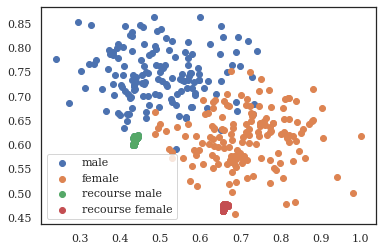

Current Centralization is 0.5
Current Atkinson is 0.9842668861352033
Current Avg Proxi Index is 0.7532966883302533
invalidation is 0.0
0.39119240595729116
0.38518430162473893
0.006008104332552222
(295, 4)
(295,)


In [12]:
hyperparams ={
"data_name": "crud", 
"target_class": [0, 1],
"lambda_param": 0.001,
"optimizer": "RMSprop",
"lr": 1e-3,
"max_iter": 2000,

"binary_cat_features": True,
"vae_params": {
    "layers":  [len(ml_model.feature_input_order)-\
            len(dataset.immutables), 256,2],
    "train": True,
    "epochs": 200,
    "lr": 1e-2,
    "batch_size": 32,
},
}
ar_model = CRUD(ml_model, hyperparams) 

negative_instances = dataset.df_train[ml_model.predict(dataset.df_train)<0.5]
negative_instances.to_csv('./balance_data/syn_negative_instances.csv')
cf = ar_model.get_counterfactuals(negative_instances)
cf.index = negative_instances.index
sensitive = "sex_1"

import matplotlib.pyplot as plt
import copy 
current_population = copy.deepcopy(dataset.df_train)

cf = encode_constraint(cf, negative_instances, [sensitive])
current_population = copy.deepcopy(dataset.df_train)
current_population.loc[negative_instances.index,['x1','x2',sensitive]] = cf[['x1','x2',sensitive]].values
current_population = current_population.dropna()
plt.scatter(current_population.x1[current_population[sensitive]==1],current_population.x2[current_population[sensitive]==1],label='male')
plt.scatter(current_population.x1[current_population[sensitive]==0],current_population.x2[current_population[sensitive]==0],label='female')
temp1 = cf['x1'][negative_instances[sensitive]==1]
temp2 = cf['x2'][negative_instances[sensitive]==1]
# randomization for visual purpose 
noise = 0
plt.scatter(temp1 + np.random.uniform(size=len(temp1)) * noise,\
    temp2 + np.random.uniform(size=len(temp2)) * noise, label = 'recourse male')
temp1 = cf['x1'][negative_instances[sensitive]==0]
temp2 = cf['x2'][negative_instances[sensitive]==0]
plt.scatter(temp1 + np.random.uniform(size=len(temp1)) * noise,\
    temp2 + np.random.uniform(size=len(temp2)) * noise, label = 'recourse female')
plt.legend()
plt.show()
plt.savefig(f'./log/synfig/syn_crud_after.pdf')
plt.close()

features = ['x1','x2']
pred = (ml_model.predict(current_population) > 0.5).reshape(-1)
predprob = (ml_model.predict(current_population)).reshape(-1)
c_central, radius = centralization(current_population[sen_feature].values, \
    current_population[features].values, 
    radius
    )
print(f'Current Centralization is {c_central}')
c_atkinson = atkinson(current_population[sen_feature].values, \
    current_population[features].values, \
    origin_features = dataset.df_train[mutable_feature].values)
print(f'Current Atkinson is {c_atkinson}')
a = current_population
b = dataset.df_train
c_ap = avg_proximity2(a[sen_feature].values, \
    a[features].values)
print(f'Current Avg Proxi Index is {c_ap}')    

inv_rate = invalidation(cf, ml_model)
print(f'invalidation is {inv_rate}')
rec_cost = recourse_cost(negative_instances, cf)

negative_sens = negative_instances[sensitive]
rec_fair = fairness_cost(negative_instances, cf, negative_sens)

vynn = ynn(dataset.df[cf.columns], cf, ml_model, 5)
close = closeness(cf[mutable_feature], dataset.df[dataset.df.y==1][mutable_feature])
result = result.append({'metric':'centralization_after', \
    'value': c_central, 'method': 'CRUD'}, ignore_index = True)
result = result.append({'metric':'atkinson_after', \
    'value': c_atkinson, 'method': 'CRUD'}, ignore_index = True)
result = result.append({'metric':'avgproxi_after', \
    'value': c_ap, 'method': 'CRUD'}, ignore_index = True)

result = result.append({'metric':'inv_rate', \
    'value': inv_rate, 'method': 'CRUD'}, ignore_index = True)
result = result.append({ 'metric':'recourse_cost', \
    'value': rec_cost,  'method': 'CRUD'}, ignore_index = True)
result = result.append({ 'metric':'recourse_faircost', \
    'value': rec_fair,  'method': 'CRUD'}, ignore_index = True) 
result = result.append({ 'metric':'ynn', \
    'value': vynn,  'method': 'CRUD'}, ignore_index = True)             
result.value = result.value.astype(float)

In [13]:
result

,metric,value,method
0,centralization_pre,0.493056,None
1,atkinson_pre,0.797725,None
2,avgproxi_pre,0.662624,None
3,centralization_after,0.500000,Watcher
4,atkinson_after,0.823536,Watcher
5,avgproxi_after,0.735595,Watcher
6,inv_rate,0.000000,Watcher
7,recourse_cost,0.296403,Watcher
8,recourse_faircost,0.015337,Watcher
9,ynn,0.649492,Watcher


# IBR

['sex_1', 'x1', 'x2']
[INFO] Start training of Variational Autoencoder... [balancevae.py fit]
[INFO] sen regularization is 1 [balancevae.py fit]
[INFO] [Epoch: 0/100] [objective: 84.572] [balancevae.py fit]
[INFO] [Epoch: 0/100] [sens objective: 0.499] [balancevae.py fit]
[INFO] [ELBO train: 84.57] [balancevae.py fit]
[INFO] [ELBO train: 79.97] [balancevae.py fit]
[INFO] [ELBO train: 79.38] [balancevae.py fit]
[INFO] [ELBO train: 79.51] [balancevae.py fit]
[INFO] [ELBO train: 80.27] [balancevae.py fit]
[INFO] [ELBO train: 80.54] [balancevae.py fit]
[INFO] [ELBO train: 80.66] [balancevae.py fit]
[INFO] [ELBO train: 81.53] [balancevae.py fit]
[INFO] [ELBO train: 81.57] [balancevae.py fit]
[INFO] [ELBO train: 81.97] [balancevae.py fit]
[INFO] [Epoch: 10/100] [objective: 82.104] [balancevae.py fit]
[INFO] [Epoch: 10/100] [sens objective: 0.503] [balancevae.py fit]
[INFO] [ELBO train: 82.1] [balancevae.py fit]
[INFO] [ELBO train: 82.5] [balancevae.py fit]
[INFO] [ELBO train: 82.56] [balance

100%|██████████| 295/295 [03:40<00:00,  1.34it/s]


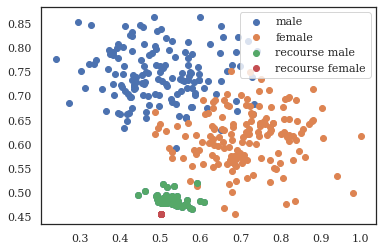

Current Centralization is 0.27692307692307694
Current Atkinson is 0.7356986795147807
Current Avg Proxi Index is 0.7799183218332438
invalidation is 0.0
0.11275767244137104
0.3300543859899606
0.2172967135485896
(295, 4)
(295,)


In [14]:
sen_feature = 'sex_1'
sen_mask = np.ones(len(ml_model.feature_input_order), dtype=bool)
print(ml_model.feature_input_order)
sen_mask[ml_model.feature_input_order.index(sen_feature)] = False
sen_mask = 1 - sen_mask
hyperparams = {
    "data_name": dataset.name,
    "n_search_samples": 100,
    "p_norm": 2,
    "step": 0.1,
    "max_iter": 2000,
    "clamp": True,
    "binary_cat_features": True,
    "vae_params": {
        "layers": [len(ml_model.feature_input_order)-\
            len(dataset.immutables), 256,128, 8],
        "train": True,
        "lambda_reg": 1e-6,
        "epochs": 100,
        "lr": 1e-3,
        "kl_weight": 1, 
        "batch_size": 64,
    },  
    "sen_mask": sen_mask, 
    "gamma": 1
}
ar_model = balanceCCHVAE(ml_model, hyperparams)

negative_instances = dataset.df_train[ml_model.predict(dataset.df_train)<0.5]
negative_instances.to_csv('./balance_data/syn_negative_instances.csv')
cf = ar_model.get_counterfactuals(negative_instances)
cf.index = negative_instances.index
sensitive = "sex_1"

import matplotlib.pyplot as plt
import copy 
current_population = copy.deepcopy(dataset.df_train)

cf = encode_constraint(cf, negative_instances, [sensitive])
current_population = copy.deepcopy(dataset.df_train)
current_population.loc[negative_instances.index,['x1','x2',sensitive]] = cf[['x1','x2',sensitive]].values
current_population = current_population.dropna()
plt.scatter(current_population.x1[current_population[sensitive]==1],current_population.x2[current_population[sensitive]==1],label='male')
plt.scatter(current_population.x1[current_population[sensitive]==0],current_population.x2[current_population[sensitive]==0],label='female')
temp1 = cf['x1'][negative_instances[sensitive]==1]
temp2 = cf['x2'][negative_instances[sensitive]==1]
# randomization for visual purpose 
noise = 0
plt.scatter(temp1 + np.random.uniform(size=len(temp1)) * noise,\
    temp2 + np.random.uniform(size=len(temp2)) * noise, label = 'recourse male')
temp1 = cf['x1'][negative_instances[sensitive]==0]
temp2 = cf['x2'][negative_instances[sensitive]==0]
plt.scatter(temp1 + np.random.uniform(size=len(temp1)) * noise,\
    temp2 + np.random.uniform(size=len(temp2)) * noise, label = 'recourse female')
plt.legend()
plt.show()
plt.savefig(f'./log/synfig/syn_ibr_after.pdf')
plt.close()

features = ['x1','x2']
pred = (ml_model.predict(current_population) > 0.5).reshape(-1)
predprob = (ml_model.predict(current_population)).reshape(-1)
c_central, radius = centralization(current_population[sen_feature].values, \
    current_population[features].values, 
    radius
    )
print(f'Current Centralization is {c_central}')
c_atkinson = atkinson(current_population[sen_feature].values, \
    current_population[features].values, \
    origin_features = dataset.df_train[mutable_feature].values)
print(f'Current Atkinson is {c_atkinson}')
a = current_population
b = dataset.df_train
c_ap = avg_proximity2(a[sen_feature].values, \
    a[features].values)
print(f'Current Avg Proxi Index is {c_ap}')    

inv_rate = invalidation(cf, ml_model)
print(f'invalidation is {inv_rate}')
rec_cost = recourse_cost(negative_instances, cf)

negative_sens = negative_instances[sensitive]
rec_fair = fairness_cost(negative_instances, cf, negative_sens)

vynn = ynn(dataset.df[cf.columns], cf, ml_model, 5)
close = closeness(cf[mutable_feature], dataset.df[dataset.df.y==1][mutable_feature])
result = result.append({'metric':'centralization_after', \
    'value': c_central, 'method': 'IBR'}, ignore_index = True)
result = result.append({'metric':'atkinson_after', \
    'value': c_atkinson, 'method': 'IBR'}, ignore_index = True)
result = result.append({'metric':'avgproxi_after', \
    'value': c_ap, 'method': 'IBR'}, ignore_index = True)

result = result.append({'metric':'inv_rate', \
    'value': inv_rate, 'method': 'IBR'}, ignore_index = True)
result = result.append({ 'metric':'recourse_cost', \
    'value': rec_cost,  'method': 'IBR'}, ignore_index = True)
result = result.append({ 'metric':'recourse_faircost', \
    'value': rec_fair,  'method': 'IBR'}, ignore_index = True) 
result = result.append({ 'metric':'ynn', \
    'value': vynn,  'method': 'IBR'}, ignore_index = True)             
result.value = result.value.astype(float)

# EBR 

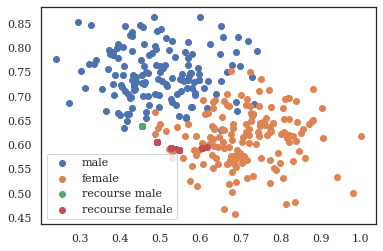

Current Centralization is 0.2951388888888889
Current Atkinson is 0.6785554729755973
Current Avg Proxi Index is 0.8342689384898623
invalidation is 0.0
0.40766916841008666
0.4610777300612426
0.05340856165115593
(295, 3)
(295,)


In [15]:
import pandas as pd 
sampled_data = pd.read_csv('./balance_data/sampled_data/balance_sampling.csv', index_col = 0)
mutable = ['x1','x2']
cf = []
sampled_data = sampled_data.sample(500)
filter_thres = 0.5
from sklearn.metrics import pairwise_distances
sampled_data_filtered = sampled_data[sampled_data.density > np.quantile(sampled_data.density,filter_thres)]
current_population = copy.deepcopy(dataset.df_train)
plt.scatter(current_population.x1[current_population.sex_1==1],current_population.x2[current_population.sex_1==1],label='male')
plt.scatter(current_population.x1[current_population.sex_1==0],current_population.x2[current_population.sex_1==0],label='female')
plt.scatter(sampled_data_filtered['x1'],sampled_data_filtered['x2'])
plt.legend()
plt.title('original distribution')
plt.close()
for i in negative_instances.index:
    thisdata = negative_instances.loc[i]
    # find closest point in sampled_data_filtered which can be accepted 
    distance = pairwise_distances(thisdata[mutable].values.reshape(1,-1), sampled_data_filtered[mutable], metric='euclidean')
    thissample = sampled_data_filtered.copy()[mutable]
    thissample['sex_1'] = thisdata['sex_1']
    result1 = ml_model.predict(thissample).reshape(-1)
    # pick the one with lowest distance 
    for j in np.argsort(distance[0]):
        if result1[j] > 0.5:
            cf.append(thissample.iloc[j])
            break
cf = pd.DataFrame(cf)
del negative_instances['y']
cf.columns = negative_instances.columns
cf.index = negative_instances.index
        
sensitive = "sex_1"

import matplotlib.pyplot as plt
import copy 
current_population = copy.deepcopy(dataset.df_train)

cf = encode_constraint(cf, negative_instances, [sensitive])
current_population = copy.deepcopy(dataset.df_train)
current_population.loc[negative_instances.index,['x1','x2',sensitive]] = cf[['x1','x2',sensitive]].values
current_population = current_population.dropna()
plt.scatter(current_population.x1[current_population[sensitive]==1],current_population.x2[current_population[sensitive]==1],label='male')
plt.scatter(current_population.x1[current_population[sensitive]==0],current_population.x2[current_population[sensitive]==0],label='female')
temp1 = cf['x1'][negative_instances[sensitive]==1]
temp2 = cf['x2'][negative_instances[sensitive]==1]
# randomization for visual purpose 
noise = 0
plt.scatter(temp1 + np.random.uniform(size=len(temp1)) * noise,\
    temp2 + np.random.uniform(size=len(temp2)) * noise, label = 'recourse male')
temp1 = cf['x1'][negative_instances[sensitive]==0]
temp2 = cf['x2'][negative_instances[sensitive]==0]
plt.scatter(temp1 + np.random.uniform(size=len(temp1)) * noise,\
    temp2 + np.random.uniform(size=len(temp2)) * noise, label = 'recourse female')
plt.legend()
plt.show()
plt.savefig(f'./log/synfig/syn_ibr_after.pdf')
plt.close()

features = ['x1','x2']
pred = (ml_model.predict(current_population) > 0.5).reshape(-1)
predprob = (ml_model.predict(current_population)).reshape(-1)
c_central, radius = centralization(current_population[sen_feature].values, \
    current_population[features].values, 
    radius
    )
print(f'Current Centralization is {c_central}')
c_atkinson = atkinson(current_population[sen_feature].values, \
    current_population[features].values, \
    origin_features = dataset.df_train[mutable_feature].values)
print(f'Current Atkinson is {c_atkinson}')
a = current_population
b = dataset.df_train
c_ap = avg_proximity2(a[sen_feature].values, \
    a[features].values)
print(f'Current Avg Proxi Index is {c_ap}')    

inv_rate = invalidation(cf, ml_model)
print(f'invalidation is {inv_rate}')
rec_cost = recourse_cost(negative_instances, cf)

negative_sens = negative_instances[sensitive]
rec_fair = fairness_cost(negative_instances, cf, negative_sens)

vynn = ynn(dataset.df[cf.columns], cf, ml_model, 5)
close = closeness(cf[mutable_feature], dataset.df[dataset.df.y==1][mutable_feature])
result = result.append({'metric':'centralization_after', \
    'value': c_central, 'method': 'EBR'}, ignore_index = True)
result = result.append({'metric':'atkinson_after', \
    'value': c_atkinson, 'method': 'EBR'}, ignore_index = True)
result = result.append({'metric':'avgproxi_after', \
    'value': c_ap, 'method': 'EBR'}, ignore_index = True)

result = result.append({'metric':'inv_rate', \
    'value': inv_rate, 'method': 'EBR'}, ignore_index = True)
result = result.append({ 'metric':'recourse_cost', \
    'value': rec_cost,  'method': 'EBR'}, ignore_index = True)
result = result.append({ 'metric':'recourse_faircost', \
    'value': rec_fair,  'method': 'EBR'}, ignore_index = True) 
result = result.append({ 'metric':'ynn', \
    'value': vynn,  'method': 'EBR'}, ignore_index = True)             
result.value = result.value.astype(float)

In [16]:
result

,metric,value,method
0,centralization_pre,0.493056,None
1,atkinson_pre,0.797725,None
2,avgproxi_pre,0.662624,None
3,centralization_after,0.500000,Watcher
4,atkinson_after,0.823536,Watcher
5,avgproxi_after,0.735595,Watcher
6,inv_rate,0.000000,Watcher
7,recourse_cost,0.296403,Watcher
8,recourse_faircost,0.015337,Watcher
9,ynn,0.649492,Watcher
